# Practical session 3 - Brownian motion, Fourier transform

Students (pair):
- [Student 1]([link](https://github.com/username1))
- [Student 2]([link](https://github.com/username2))

In [10]:
%load_ext autoreload
%autoreload 2

## <a> name="ex1"Exercise 1: Brownian motion</a>

This first exercise consists in generating a Brownian motion on the closed unit ball $\mathcal{B}(\mathbf{0}, 1) = \{ \mathbf{x} \mid \Vert \mathbf{x} \Vert  \leq 1\}$, focusing first on the 2-D case. The Brownian motion is a random walk with independent, identically distributed Gaussian increments, appearing for instance in thermodynamics and statistical mechanics (to model the evolution of a large particle in a medium composed of a large number of small particles, ...). It is also connected to the diffusion process (Einstein).

Let $N \in \mathbb{N}^*$, $\delta  0$, and $\mathbf{x} = (x_1, x_2) \in  \mathcal{B}(\mathbf{0}, 1)$. The first $N$ steps of a 2-D discrete-time Brownian motion $W$ can be generated as follows

\begin{align*}
    W_0 &= \mathbf{x}, \\
    %
    (\forall n \in \{1, \dotsc, N-1 \}), \quad W_n &= W_{n−1} + \sqrt{\delta} G_n, \quad G_n \sim \mathcal{N}(\mathbf{0}, \mathbf{I}),
\end{align*}

where $\mathcal{N}(\mathbf{0}, \mathbf{I})$ is a Gaussian distribution with mean $\mathbf{0}$ and identity covariance matrix.

1. Define a random generator `rng`, set to a known state for reproducibility (see session 2).

**Answer:**

In [11]:
# your code
import numpy as np
rng = np.random.default_rng(84548)

2. Implement a function `brownian_motion(niter, x, step, rng)` which

    - simulates $W$ until it reaches the boundary of $\mathcal{B}(\mathbf{0}, 1)$, using a maximum of $N$ iterations (`niter`), a starting point $\mathbf{x} \in \mathcal{B}(\mathbf{0}, 1)$ (`x`) and step-size $\delta$ (`step`);
    - interpolates linearly between the two last positions to determine the points $W^*$ where the trajectory crosses the boundary (if applicable);
    - returns both the whole random walk $W$ and, if appropriate, the point at the intersection between the last segment of the trajectory and $\mathcal{B}(\mathbf{0}, 1)$.
 
 Hint: 
 - you can easily derive a closed form expression for $W^*$, observing that $\Vert W^* \Vert^2= 1$ and $W^* \in [W_{n-1}, W_n]$. 
 - you can also take a look at [`np.roots`](https://numpy.org/doc/stable/reference/generated/numpy.roots.html?highlight=roots#numpy.roots) if needed.

**Answer:**

In [12]:
# your code
from sympy import symbols, Eq, solve

def dot(v,w): return v[0]*w[0] + v[1]*w[1]
def wedge(v,w): return v[0]*w[1] - v[1]*w[0]

def is_between(a,b,c):
   v = a - b
   w = b - c
   return abs(wedge(v,w)) <= 10e-6 and dot(v,w) > 0

def brownian_motion(niter, x, step, rng):
    """The Brownian motion is a random walk with independent, identically distributed Gaussian increments, appearing for instance in thermodynamics and statistical mechanics (to model the evolution of a large particle in a medium composed of a large number of small particles, ...). It is also connected to the diffusion process (Einstein).
    generating a Brownian motion on the closed unit ball $\mathcal{B}(\mathbf{0}, 1) = \{ \mathbf{x} \mid \Vert \mathbf{x} \Vert  \leq 1\}$

    Args:
        niter (int): Maximum of iterations
        x (array): Starting point in the ball
        step (int): Step-size
        rng (numpy.random._generator.Generator): Random generator

    Returns:
        array: Trajectory of the random walk
    """
    n=0
    W = x
    W_list = [W]
    assert step>0, "step must be strictly positive"
    while n<niter and (W.T@W<1):
        n+=1
        W = W+np.sqrt(step)*np.random.multivariate_normal([0 for _ in range(x.shape[0])], np.identity(x.shape[0]))
        if W.T@W==1:
            W_list.append(W)
            break
        elif W.T@W<1:
            W_list.append(W)
        else:
            x, y = symbols('x y')

            eq1 = Eq(x**2 + y**2,1)
            a = (W[1] - W_list[-1][1])/(W[0] - W_list[-1][0])
            b = W[1] - a*W[0]
            eq2 = Eq(a*x + b, y)
            sol_dict = solve((eq1,eq2), (x, y)) 
            sol_one = np.array(sol_dict[0])
            sol_two = np.array(sol_dict[1])
            
            if  is_between(W_list[-1], sol_one, W):
                W_list.append(sol_one)   
            else:
                W_list.append(sol_two)
    return np.stack(W_list, axis=0)

3. Diplay the trajectory of a Brownian motion starting from $\mathbf{x} = (0.2, 0.4)$, using $\delta = 10^{-2}$, $N = 1000$. Display the unit circle on the same figure, and highlight the intersection with the boundary of the domain (whenever it exists).

> Hint: to draw the unit disk, you can use for instance:
> ```python
> circle = plt.Circle((0,0), 1)
> fig, ax = plt.subplots()
> plt.xlim(-1.25,1.25)
> plt.ylim(-1.25,1.25)
> plt.grid(linestyle = "--", zorder = 1)
> ax.set_aspect(1)
> ax.add_artist(circle)
> ```

**Answer:**

In [13]:
# your code
list_points = brownian_motion(1000, np.array([0.2,0.4]), 10e-2, rng)

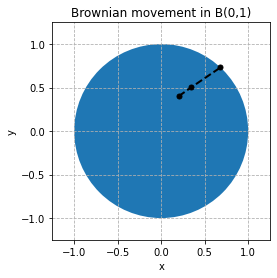

In [14]:
import matplotlib.pyplot as plt
circle = plt.Circle((0,0), 1)
fig, ax = plt.subplots()
plt.xlim(-1.25,1.25)
plt.ylim(-1.25,1.25)
plt.grid(linestyle = "--", zorder = 1)
plt.gca().add_patch(circle)
ax.set_aspect(1)
ax.plot(list_points[:,0], list_points[:,1], 'o--', lw=2, color='black', ms=5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Brownian movement in B(0,1)')
fig.savefig("figures/brownian_motion_1000_0.01.png")

4. Represent, on the same figure, 4 other trajectories of $W$ with the same parameters.

**Answer:**

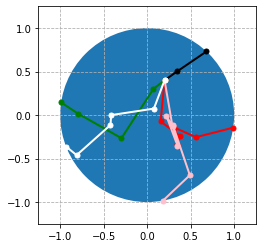

In [15]:
trajectories = [list_points] + [brownian_motion(1000, np.array([0.2,0.4]), 10e-2, rng) for _ in range(4)]
circle = plt.Circle((0,0), 1)
fig, ax = plt.subplots()
plt.xlim(-1.25,1.25)
plt.ylim(-1.25,1.25)
plt.grid(linestyle = "--", zorder = 1)
plt.gca().add_patch(circle)
ax.set_aspect(1)
colors = ['black', 'red', 'green', 'pink', 'white']
for i in range(5):
    ax.plot(trajectories[i][:,0], trajectories[i][:,1], 'o-', lw=2, color=colors[i], ms=5)
fig.savefig("figures/brownian_motion_5_trajectories.png")

5. [Bonus] Generalize the procedure to a $M$-dimensional Brownian motion, $M  2$.

**Answer:**

In [16]:
# your code

---
## <a> name="ex2"Exercise 2: 2D Fourier transform, ideal low-pass filter and linear convolution</a>

In this exercise, we explore the use of the 2-dimensional Fourier transform to filter an image, and convolve it with a blurring kernel.

1\. Load and display one of the images contained in the `img/` folder. The image will be denoted by $\mathbf{X} \in \mathbb{R}^{M_1 \times N_1}$ in the rest of this exercise.

**Answer:**

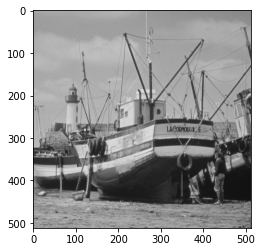

In [17]:
# your code
import matplotlib.pyplot as plt

img = plt.imread('img/boat.png', 0)
plt.imshow(img)

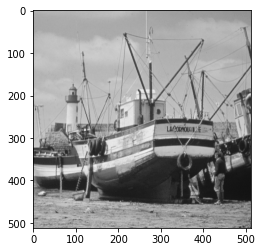

In [18]:
from PIL import Image
image = Image.open("img/boat.png")
gray_img = image.convert("L")
plt.imshow(gray_img, cmap='gray')

----------------------------------------------------------------

2\. Let $\mathcal{F}$ denote the 2D discrete Fourier transform. Compute $|\mathcal{F}(\mathbf{X})|^2$, the spectrum of the image $\mathbf{X} \in \mathbb{R}^{M_1 \times N_1}$ (i.e., the term-wise squared absolute value of its Fourier transform) loaded in 1. Display the result in logarithmic scale.

a) In this representation, where is the pixel of the spectrum associated with the null frequency located?
    
b) Take a look at the documentation of `np.fft.fftshift`. Use it to ensure that the null frequency is located at the center of the image. 

**Answer:**

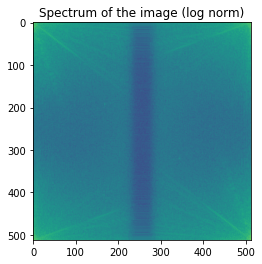

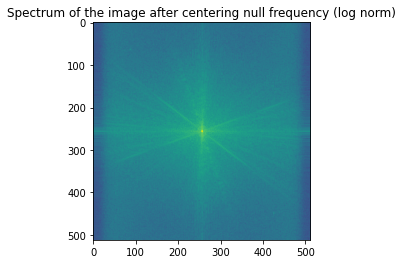

In [19]:
import numpy as np
from matplotlib.colors import LogNorm

# Spectrum of the image
dft_gray_img = np.fft.fft2(gray_img)
spectrum = np.vectorize(lambda x: np.abs(x)**2)(dft_gray_img)
plt.figure()
plt.title("Spectrum of the image (log norm)")
plt.imshow(spectrum, norm=LogNorm())

# Spectrum of the image after centering null frequency
dft_gray_img = np.fft.fftshift(dft_gray_img)
spectrum = np.vectorize(lambda x: np.abs(x)**2)(dft_gray_img)
plt.figure()
plt.title("Spectrum of the image after centering null frequency (log norm)")
plt.imshow(spectrum, norm=LogNorm())

In the first representation, the null frequency is located in dft_gray_img[0] whereas after the np.fft.fftshift the null frequency is located at the center of the image (i.e. at the center of dft_gray_img).

In bonus, we show the phase of the image before and after centralizing the null frequency

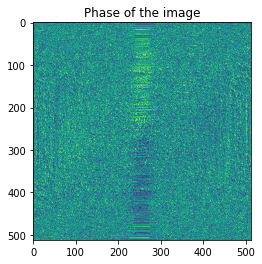

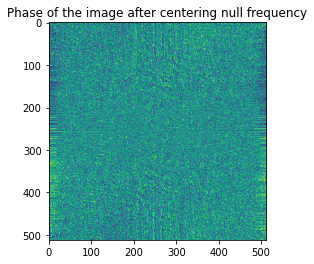

In [20]:
import cmath

# Phase of the image
dft_gray_img = np.fft.fft2(gray_img)
phase = np.vectorize(lambda x: cmath.phase(x))(dft_gray_img)
plt.figure()
plt.title("Phase of the image")
plt.imshow(phase)

# Phase of the image after centering null frequency
dft_gray_img = np.fft.fftshift(dft_gray_img)
phase = np.vectorize(lambda x: cmath.phase(x))(dft_gray_img)
plt.figure()
plt.title("Phase of the image after centering null frequency")
plt.imshow(phase)

----------------------------------------------------------------

3\. 
    a) Create a function `ideal_lowpass_filter` to filter $\mathbf{X}$ by an ideal low-pass filter. The filter preserves Fourier coefficients associated to frequencies below a cutoff specified in each direction ($\mathbf{f}_c = (f_{c,y}, f_{c,x})$), and sets others to zero. For simplicity, $f_{c,y}$ and $f_{c,x}$ can be expressed as a number of samples to be kept along each dimension (e.g., $\mathbf{f}_c = (50,50)$).

b) Display the filtered image for 2 different values of $\mathbf{f}_c$. What do you observe as the cutoff frequencies increase?
    
 Warning: beware the type of the array after `np.fft.fft2`, do not hesitate to specify the type if you make copies from this array
 ```python
 a = np.zeros((2,2), dtype=np.complex)
 ...
 ```

**Answer:**

In [21]:
def ideal_lowpass_filter(x, fc):
    """Returns a low pass filter on a 2D array

    Args:
        x (array): The 2D array to be filtered
        fc ((float, float)): Cutoff frequencies

    Returns:
        array: The 2D array after the low pass filter
    """
    dft_x = np.fft.fft2(x)
    dft_x = np.fft.fftshift(dft_x)
    M,N = dft_x.shape
    dft_x_low_pass = dft_x[M//2-fc[0]//2:M//2+fc[0]//2, N//2-fc[1]//2:N//2+fc[1]//2]
    return np.fft.ifft2(dft_x_low_pass)

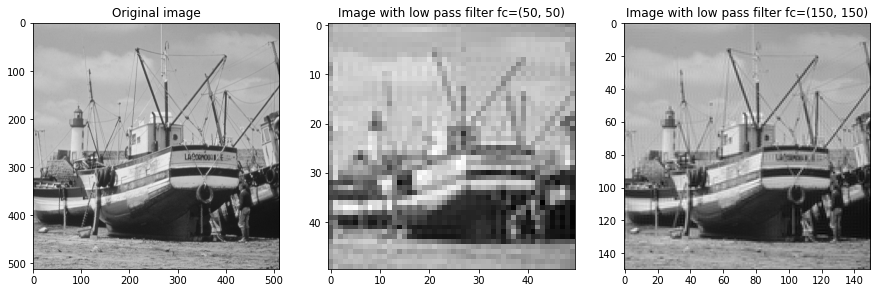

In [22]:
fc1, fc2 = (50, 50), (150, 150)
new_gray_img_1 = ideal_lowpass_filter(gray_img, fc1)
new_gray_img_2= ideal_lowpass_filter(gray_img, fc2)

new_gray_img_1 = np.abs(new_gray_img_1)
new_gray_img_2 = np.abs(new_gray_img_2)

fig, ax = plt.subplots(1,3)
fig.set_figheight(15)
fig.set_figwidth(15)

ax[0].set_title("Original image")
ax[0].imshow(gray_img, cmap="gray")

ax[1].set_title(f"Image with low pass filter fc={fc1}")
ax[1].imshow(new_gray_img_1, cmap="gray")

ax[2].set_title(f"Image with low pass filter fc={fc2}")
ax[2].imshow(new_gray_img_2, cmap="gray")

fig.savefig("figures/ideal_lowpass_filter.png")

As the cutoff frequencies increase, we observe that the filtered image look like more and more like the original image. When the cutoff frequencies decrease the filtered image gets increasingly blurred. This makes sense given that with low cutoff frequencies, there are less frequencies in the Fourier transform which impacts the resolution of the returned image.

----------------------------------------------------------------

4\. Let $\mathbf{H} \in \mathbb{R}^{M_2\times N_2}$ be a 2-D Gaussian kernel, obtained as the outer product of two 1-D Gaussian windows $\mathbf{w}_y \in \mathbb{R}^{M_2}$ and $\mathbf{w}_x \in \mathbb{R}^{N_2}$, of standard deviation $\sigma_y = 10$ and $\sigma_x = 10$, respectively:

\begin{equation}
    \mathbf{H} = \mathbf{w}_y \mathbf{w}_x^T.
\end{equation}

Let $M = M_1+M_2-1$ and $N =  N_1+N_2-1$. From the discrete convolution theorem, the linear convolution between $\mathbf{H}$ and $\mathbf{X}$ can be computed as follows

\begin{equation}
    \mathbf{X} \star \mathbf{H} =P_1^* \bigg( \mathcal{F}^{-1} \Big( \mathcal{F}\big(P_1(\mathbf{X})\big) \odot \mathcal{F}\big(P_2(\mathbf{H})\big) \Big) \bigg) \in \mathbb{R}^{M\times N},
\end{equation}

where $P_i: \mathbb{R}^{M_i \times N_i} \rightarrow \mathbb{R}^{M \times N}$, $i \in \{1, 2\}$, are 0-padding operators, $\odot$ is the Hadamard (= term-wise) product, $\mathcal{F}^{-1}$ is the 2D discrete inverse Fourier transform and $P_1^*$ is a cropping operator (adjoint of $P_1$). 

Compute and display $\mathbf{X} \star \mathbf{H}$, for $M_2 = N_2 = 10$. What do you observe?

 Hint: 
 - the usual 0-padding procedure in image space consists in appending trailing zeros. For instance (in 1D), 0-padding a vector $\mathbf{x} \in \mathbb{R}^N_1$ to the size $NN_1$ corresponds to creating the vector
\begin{bmatrix}
\mathbf{x} \\
\mathbf{0}_{N-N_1}
\end{bmatrix}
 - since the input images are real, $\mathcal{F}(\mathbf{x})$ and $\mathcal{F}(\mathbf{h})$ are Hermitian symmetric. In this case, a more efficient version of `np.fft.fft2` can be used, computing only quarter of the Fourier coefficients (half of the Fourier coefficients in each direction): [`np.fft.rfft2`](https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft2.html?highlight=rfft#numpy.fft.rfft2). Its inverse, [`np.fft.irfft2`](https://numpy.org/doc/stable/reference/generated/numpy.fft.irfft2.html#numpy.fft.irfft2), also ensures that the output is real;
 - the 2D Gaussian window can be generated as the outer product of two 1D Gaussian windows (one window for each dimension);
 - you can take a look at [scipy.signal.windows.gaussian](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.gaussian.html#scipy.signal.windows.gaussian) and [np.newaxis](https://numpy.org/doc/stable/reference/constants.html?highlight=newaxis#numpy.newaxis).

**Answer:**

In [23]:
def gaussian_filter_2d(x, h):
    """_summary_

    Args:
        x (array): The 2D array to be filtered
        h (array): 2D Gaussian kernel obtained from the outer product of two gaussian windows

    Returns:
        array: The 2D array after the gaussian filter
    """
    M1 = x.shape[0]
    N1 = x.shape[1]
    M2 = h.shape[0]
    N2 = h.shape[1]
    M = M1 + M2 - 1
    N = N1 + N2 - 1

    P1_x = np.pad(x, ((0,M-M1), (0,N-N1)), 'constant', constant_values=(0))
    P2_h = np.pad(h, ((0,M-M2), (0,N-N2)), 'constant', constant_values=(0))
    dft_P1_x = np.fft.rfft2(P1_x)
    dft_P2_h = np.fft.rfft2(P2_h)
    hadamard = np.multiply(dft_P1_x, dft_P2_h)
    inv = np.fft.irfft2(hadamard)
    return inv[:M1, :N1]

In [25]:
from scipy.signal import windows

M2 = 10
N2 = 10

w_x = windows.gaussian(N2,10).reshape((N2,1))
w_y = windows.gaussian(M2,10).reshape((M2,1))
h = w_y @ w_x.T

res_img = gaussian_filter_2d(np.array(gray_img), h)

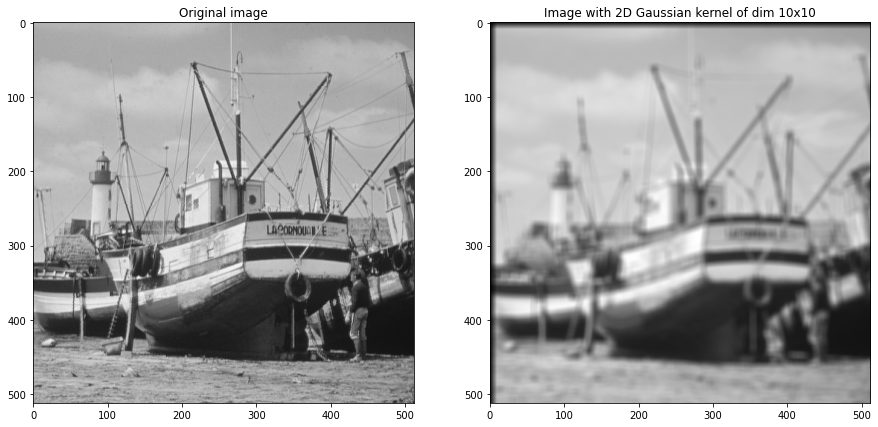

In [26]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(15)
fig.set_figwidth(15)

ax[0].set_title("Original image")
ax[0].imshow(gray_img, cmap="gray")

ax[1].set_title(f"Image with 2D Gaussian kernel of dim {M2}x{N2}")
ax[1].imshow(res_img, cmap="gray")

fig.savefig("figures/2D_gaussian_kernel_10x10.png")